<a href="https://colab.research.google.com/github/torrozz/Graduation/blob/main/Graduation_verMetasatic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf ~/.kaggle


In [ ]:
# Cài đặt thư viện Kaggle CLI để tải dataset
!pip install -q kaggle


In [ ]:
# Tải tệp kaggle.json từ máy lên Colab
from google.colab import files
files.upload()  # Chọn file kaggle.json sau khi chạy


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nguyntntjason","key":"a77661f4fc309da9ac836ae66d9cbd10"}'}

In [ ]:
# Tạo thư mục cấu hình và cấp quyền cho kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# Tải toàn bộ dữ liệu từ cuộc thi histopathologic-cancer-detection
!kaggle competitions download -c histopathologic-cancer-detection



^C


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -q "/content/drive/MyDrive/histopathologic-cancer-detection.zip" -d /content/histopathologic_data


In [ ]:
!ls /content/histopathologic_data


sample_submission.csv  test  train  train_labels.csv


In [ ]:
# Cài đặt thư viện fastai nếu chưa có
!pip install -q fastai

# Import thư viện cần thiết
from fastai.vision.all import *
import pandas as pd
from pathlib import Path


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.7 MB/s eta 0:00:00


In [ ]:
# Đường dẫn dữ liệu
path = Path('/content/histopathologic_data')

# Đọc file nhãn
df = pd.read_csv(path/'train_labels.csv')

# Thêm phần mở rộng .tif để khớp tên file ảnh
df['id'] = df['id'].apply(lambda x: f"{x}.tif")

# Đổi tên cột cho phù hợp với FastAI (id → fname, label → label)
df = df.rename(columns={"id": "fname", "label": "label"})

# Xem 5 dòng đầu
df.head()


,fname,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


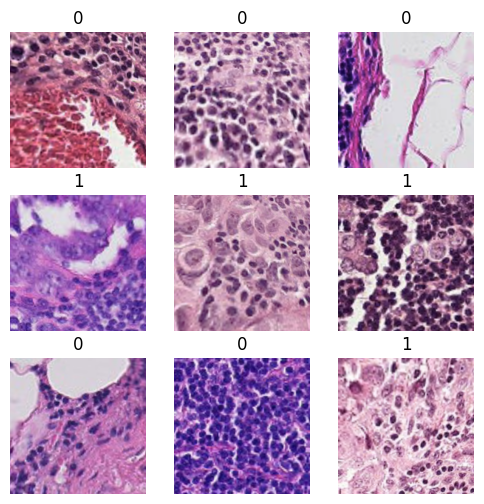

In [ ]:
# Chia dữ liệu train/valid (80/20)
dls = ImageDataLoaders.from_df(
    df,                           # DataFrame chứa dữ liệu ảnh
    path=path/'train',           # Đường dẫn gốc đến thư mục chứa ảnh
    fn_col='fname',              # Cột chứa tên file ảnh
    label_col='label',           # Cột chứa nhãn (class)
    valid_pct=0.2,               # Tự động chia 20% ảnh cho validation
    seed=42,                     # Đảm bảo chia cố định
    item_tfms=Resize(460),       # Resize lớn để giữ chi tiết
    batch_tfms=aug_transforms(   # Data augmentation
        size=224,                # Sau đó crop về 224x224
        flip_vert=True,
        max_rotate=20,
        max_zoom=1.2,
        max_lighting=0.3,
        max_warp=0.3,
        p_affine=0.75,
        p_lighting=0.75
    ),
    bs=64                        # Batch size
)

# Hiển thị 1 batch ảnh
dls.show_batch(max_n=9, figsize=(6,6))


In [ ]:
# Khởi tạo mô hình learner với ResNet50
learn = cnn_learner(
    dls,                # DataLoaders đã tạo
    resnet50,           # Kiến trúc backbone
    metrics=accuracy,   # Đo lường độ chính xác
    pretrained=True     # Dùng trọng số ImageNet
)


/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 91.2MB/s]


SuggestedLRs(valley=0.0012022644514217973)

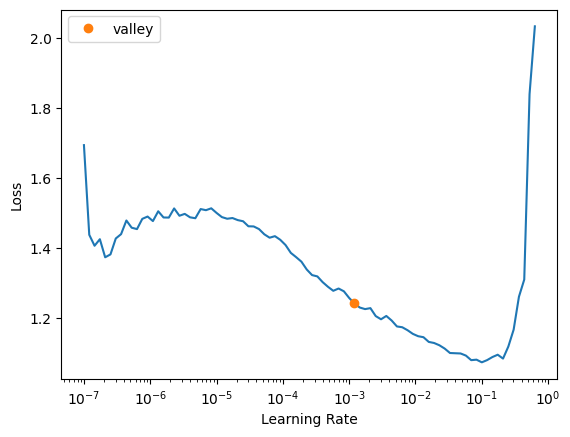

In [ ]:
# Tìm learning rate phù hợp
learn.lr_find()


In [ ]:
learn.fine_tune(5, base_lr=2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.340884,0.287700,0.878732,34:06


epoch,train_loss,valid_loss,accuracy,time
0,0.254104,0.229572,0.904657,43:24
1,0.226577,0.209243,0.912134,43:14
2,0.212750,0.199513,0.917449,43:04


epoch,train_loss,valid_loss,accuracy,time
0,0.254104,0.229572,0.904657,43:24
1,0.226577,0.209243,0.912134,43:14
2,0.212750,0.199513,0.917449,43:04
3,0.194797,0.189255,0.922295,43:08
4,0.188351,0.187737,0.923052,42:59


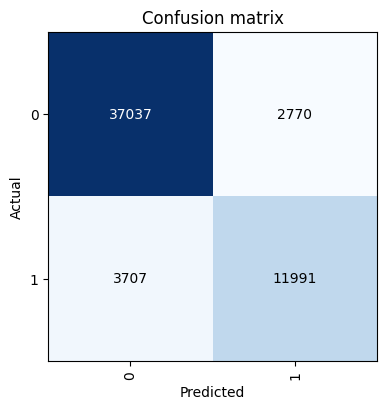

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4), dpi=100)


In [ ]:
learn.export("/content/metastatic_model.pkl")

In [ ]:
from google.colab import files
files.download("/content/metastatic_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📤 Upload ảnh bất kỳ (png/jpg/tif)...


Saving 00039ed67c14391535d5ac933cc4854619849738.tif to 00039ed67c14391535d5ac933cc4854619849738.tif


📌 Kết quả dự đoán: 1
✅ Non-Metastatic (0): 0.0003 | 🧬 Metastatic (1): 0.9997


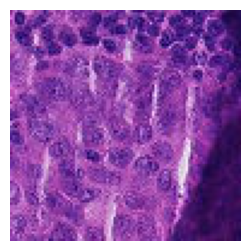

In [ ]:
from fastai.vision.all import *
from google.colab import files
from PIL import Image

# --- 1. Load mô hình ---
learn_inf = load_learner("/content/metastatic_model.pkl")  # Đổi đường dẫn nếu khác

# --- 2. Upload ảnh ---
print("📤 Upload ảnh bất kỳ (png/jpg/tif)...")
uploaded_img = files.upload()
img_filename = next(iter(uploaded_img))  # Lấy tên file

# --- 3. Chuyển đổi sang .tif nếu cần ---
# Lấy đuôi ảnh (.jpg, .png...)
img_ext = img_filename.split('.')[-1].lower()

if img_ext != 'tif':
    # Chuyển ảnh sang .tif để predict chuẩn định dạng training
    img_raw = Image.open(img_filename).convert('RGB')
    tif_path = img_filename.rsplit('.', 1)[0] + ".tif"
    img_raw.save(tif_path)
    img_filename = tif_path  # cập nhật lại tên file đã convert

# --- 4. Dự đoán ---
img = PILImage.create(img_filename)
pred_class, pred_idx, probs = learn_inf.predict(img)

# --- 5. Hiển thị ---
img.show(figsize=(3,3))
print(f"📌 Kết quả dự đoán: {pred_class}")
print(f"✅ Non-Metastatic (0): {probs[0]:.4f} | 🧬 Metastatic (1): {probs[1]:.4f}")

